In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
import pickle
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
print(tf.config.list_physical_devices('GPU'))
import matplotlib.pyplot as plt

[]


In [2]:
BATCH_SIZE = 64
LR = 1e-4

In [3]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [4]:
def get_dataset(rank):
    with open(f'data/matches/{rank}.ds', 'rb') as f:
        training_data = pickle.load(f)
    normalizer.adapt(training_data[0])
    ds = tf.data.Dataset.from_tensor_slices(training_data)
    ds = ds.cache().shuffle(training_data[0].shape[0], reshuffle_each_iteration=False).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds
ds = get_dataset('platinum')

In [5]:
train_len = int(len(ds) * 0.8)
val_len = int(len(ds) * 0.1)
test_len = len(ds) - (train_len + val_len)

train = ds.take(train_len)
val = ds.skip(train_len).take(val_len)
test = ds.skip(train_len + val_len)

In [6]:
def create_model():
    model = keras.Sequential()
    model.add(normalizer)
    model.add(layers.Dense(256, kernel_initializer='lecun_normal', bias_initializer='zeros', activation='selu'))
    model.add(layers.Dense(128, kernel_initializer='lecun_normal', bias_initializer='zeros', activation='selu'))
    model.add(layers.Dense(64, kernel_initializer='lecun_normal', bias_initializer='zeros', activation='selu'))
    model.add(layers.Dense(32, kernel_initializer='lecun_normal', bias_initializer='zeros', activation='selu'))
    model.add(layers.Dense(16, kernel_initializer='lecun_normal', bias_initializer='zeros', activation='selu'))
    model.add(layers.Dense(1, kernel_initializer='he_uniform', bias_initializer='zeros'))
    return model
model = create_model()

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 321)              643       
 n)                                                              
                                                                 
 dense (Dense)               (None, 256)               82432     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                        

In [8]:
optimizer = optimizers.Adam(learning_rate=LR)
loss = losses.BinaryCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=[tf.keras.metrics.BinaryAccuracy()])

In [9]:
history = model.fit(train, validation_data=val, epochs=5)

Epoch 1/5
1913/1913 [==============================] - 3s 1ms/step - loss: 0.4763 - binary_accuracy: 0.7405 - val_loss: 0.3994 - val_binary_accuracy: 0.7994
Epoch 2/5
1913/1913 [==============================] - 3s 1ms/step - loss: 0.3321 - binary_accuracy: 0.8408 - val_loss: 0.2513 - val_binary_accuracy: 0.8950
Epoch 3/5
1913/1913 [==============================] - 3s 1ms/step - loss: 0.1801 - binary_accuracy: 0.9274 - val_loss: 0.1256 - val_binary_accuracy: 0.9550
Epoch 4/5
1913/1913 [==============================] - 3s 1ms/step - loss: 0.0795 - binary_accuracy: 0.9733 - val_loss: 0.0580 - val_binary_accuracy: 0.9844
Epoch 5/5
1913/1913 [==============================] - 3s 1ms/step - loss: 0.0335 - binary_accuracy: 0.9910 - val_loss: 0.0335 - val_binary_accuracy: 0.9915


In [10]:
history_dic = history.history
history_dic.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

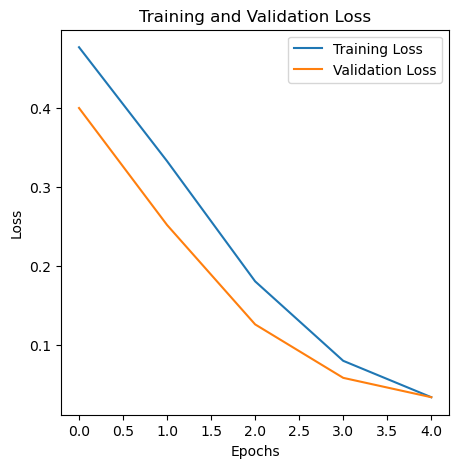

In [11]:
plt.figure(figsize=(5, 5))
plt.plot(history_dic['loss'], label='Training Loss')
plt.plot(history_dic['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

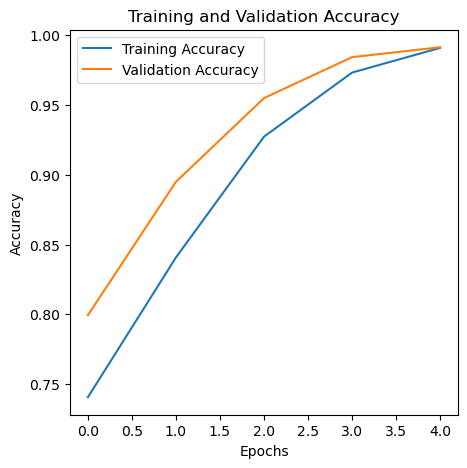

In [12]:
plt.figure(figsize=(5, 5))
plt.plot(history_dic['binary_accuracy'], label='Training Accuracy')
plt.plot(history_dic['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
loss, accuracy = model.evaluate(test)
print('Loss:', loss)
print('Accuracy:', accuracy)

240/240 [==============================] - 0s 770us/step - loss: 0.0355 - binary_accuracy: 0.9907
Loss: 0.03546202555298805
Accuracy: 0.9906523823738098


In [22]:
export_model = keras.Sequential([
    model,
    layers.Activation('sigmoid')
])

In [23]:
export_model.save('live-model.h5')